In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import networkx as nx

import torch 
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter, Linear
import torch_geometric as tgm
from torch_geometric.data import DataLoader

In [2]:
fnames = ['CTCF mean',
         'CTCF diff',
         'Smc3 mean',
         'Smc3 diff',
         'k27ac mean',
         'k27ac diff',
         'Nanog mean',
         'Nanog diff',
         'Nanog mean',
         'Nanog diff',
         'k4me3 mean',
         'k4me3 diff',
         'chd4 mean',
         'chd4 diff']

In [3]:
def torch_to_nx(arch, fnames= fnames):
    G = nx.Graph()
    G.add_nodes_from([(idx, 
                     {fnames[jdx]: arch.x.numpy()[idx,jdx] for jdx in np.arange(len(fnames))
                     }
                     ) for idx in np.arange(arch.x.numpy().shape[0])
                     ]
                   )
    G.add_edges_from([(arch.edge_index.numpy()[0,idx],
                       arch.edge_index.numpy()[1,idx],
                     {'mean_weight': arch.edge_attr.numpy()[idx,0],
                      'diff_weight': arch.edge_attr.numpy()[idx,1]}
                     ) for idx in np.arange(arch.edge_index.numpy().shape[1])
                     ])
    
    return G, arch.name

In [4]:
def symlog(vec):
    out = vec.copy()
    out[vec>1]=1+np.log(out[vec>1])

    return out

def draw_graph(G,
               ax, 
               weight = 'mean_weight',
               color_nodes_by = 'Mbd3',
               node_cmap = 'Blues',
               edge_cmap = 'Reds',
               log_node_color = True,
               log_edge_weight = True
               ):
  
    pos = nx.spring_layout(G, weight = weight)

    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist = [25],
                           node_size = 500,
                           node_color = 'red',
                           ax = ax
                           )

    node_cols = np.array([G.nodes[node][color_nodes_by] for node in G.nodes()])
    if log_node_color:
        node_cols = symlog(node_cols)

    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_color=node_cols,
                           cmap = node_cmap,
                           node_size = 150,
                           ax = ax
                           )
    
    edge_weights = np.array([G[edge[0]][edge[1]][weight] for edge in G.edges()])
    print(np.min(edge_weights),np.max(edge_weights))
    if log_edge_weight:
        edge_weights = symlog(edge_weights)

    nx.draw_networkx_edges(G,
                           pos,
                           edge_color = edge_weights,
                           edge_cmap = plt.cm.Greys,
                           connectionstyle = 'arc3,rad=0.2',
                           ax = ax 
                           )
    
    nx.draw_networkx_edges(G,
                           pos,
                           edgelist = [edge for edge in G.edges() if abs(edge[0]-edge[1])==1],
                           edge_color = 'red',
                           width = 2,
                           connectionstyle = 'arc3,rad=0.2',
                           ax = ax 
                           )
    
    
    


In [5]:
DATASET = "Data/dset_15difffeatures_500kb_wayneRNAseq.pt"
dset = torch.load(DATASET)

0.004974143 1.0
-0.3262705 0.58757603


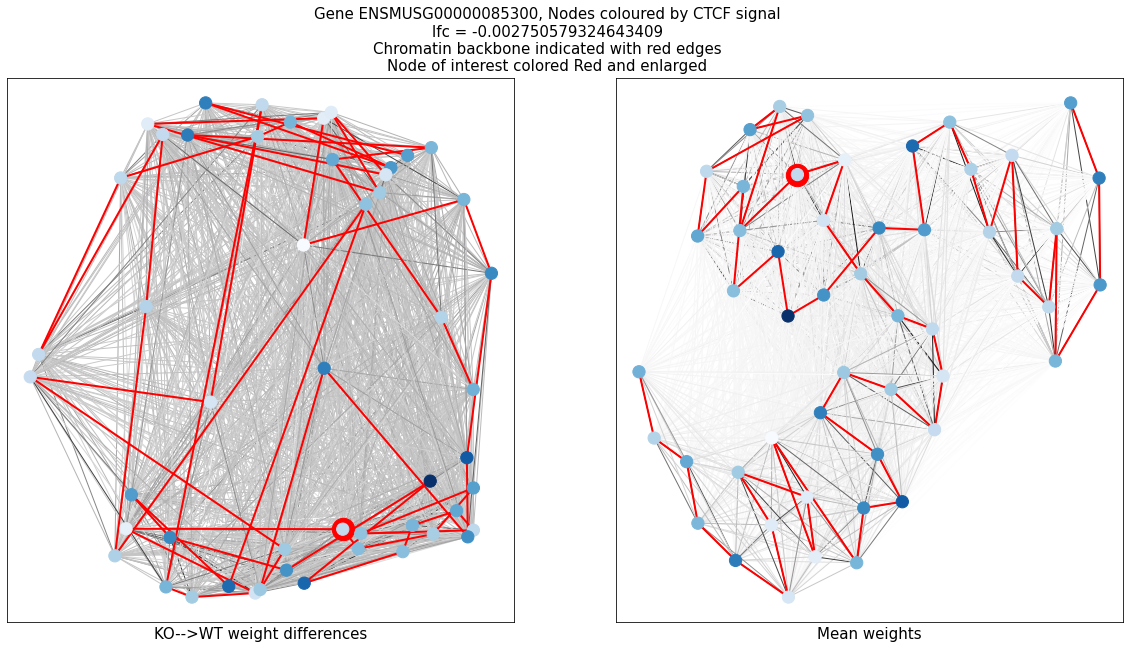

In [45]:
fig,ax = plt.subplots(1,2, figsize = (20,10))
node_col_mean = 'CTCF mean'
node_col_diff = 'CTCF diff'
idx = 0

dat,name = torch_to_nx(dset[idx])
draw_graph(dat,
           ax[1],
           color_nodes_by=node_col_WT,
           weight = 'mean_weight',
           log_edge_weight = True
          )
ax[1].set_xlabel("Mean weights", size = 15)

draw_graph(dat,
           ax[0],
           color_nodes_by=node_col_KO, 
           weight = 'diff_weight')
ax[0].set_xlabel("KO-->WT weight differences", size = 15)

title = fig.suptitle(f"Gene {name}, Nodes coloured by CTCF signal\nlfc = {dset[idx].y}\nChromatin backbone indicated with red edges\nNode of interest colored Red and enlarged",
         size = 15)

In [8]:
dset[1].edge_attr

tensor([[ 0.1402, -0.2805],
        [ 0.0410, -0.0821],
        [ 0.0598,  0.1196],
        [ 0.5000, -1.0000],
        [ 0.0815,  0.0144],
        [ 0.0944,  0.1654],
        [ 0.1098,  0.0552],
        [ 0.0881,  0.0538],
        [ 0.0710, -0.1419],
        [ 1.0000,  0.0000],
        [ 0.8765,  0.2470],
        [ 0.9145,  0.1710],
        [ 0.0894, -0.1788],
        [ 0.5955,  0.3324],
        [ 0.1257, -0.2514],
        [ 0.4855,  0.4001],
        [ 0.1170, -0.2340],
        [ 0.4091,  0.1932],
        [ 0.0623, -0.1245],
        [ 0.0415, -0.0831],
        [ 0.5000, -1.0000],
        [ 0.0446, -0.0891],
        [ 0.0710, -0.1419],
        [ 0.0761, -0.1523],
        [ 0.1029, -0.2058],
        [ 0.5000, -1.0000],
        [ 0.3507, -0.7014],
        [ 0.5000, -1.0000],
        [ 0.7391,  0.5218],
        [ 0.1634, -0.3269],
        [ 0.0277, -0.0555],
        [ 0.0815,  0.0144],
        [ 0.0761, -0.1523],
        [ 0.0868, -0.1736],
        [ 0.5000, -1.0000],
        [ 0.1767, -0